In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD



# Latent matrix from metadata

In [32]:
df = pd.read_csv('2019_oct_sort_1000.csv')

In [33]:
df.shape

(1000, 9)

In [264]:
def preprocessing_feat(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [233]:
X_preprocessed = preprocessing_feat(df)

/tmp/ipykernel_1009/2506758687.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [234]:
X_preprocessed.shape

(609, 9)

In [261]:
X_preprocessed['user_id'].nunique()

186

## Pricing criterion

In [142]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="left")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [144]:
X_merged = pricing_criterion(X_preprocessed)

In [147]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [150]:
X_meta = metadata(X_merged)

In [154]:
X_meta.shape

(389, 8)

In [162]:
X_meta

,product_id,category_code,brand,price,metadata,25%,75%,price_category
0,1005105,electronics smartphone,apple,1349.46,electronics smartphone apple high,217.910,720.5125,high
1,1005115,electronics smartphone,apple,955.84,electronics smartphone apple high,217.910,720.5125,high
2,1005104,electronics smartphone,apple,993.27,electronics smartphone apple high,217.910,720.5125,high
3,1005212,electronics smartphone,samsung,193.39,electronics smartphone samsung low,217.910,720.5125,low
4,1004858,electronics smartphone,samsung,131.53,electronics smartphone samsung low,217.910,720.5125,low
...,...,...,...,...,...,...,...,...
384,1401872,computers desktop,netechnics,630.62,computers desktop netechnics medium,191.250,772.1900,medium
385,1401582,computers desktop,avalon,797.94,computers desktop avalon high,191.250,772.1900,high
386,5100337,electronics clocks,apple,321.47,electronics clocks apple low,321.475,454.8200,low
387,4802036,electronics audio headphone,apple,174.96,electronics audio headphone apple high,25.470,160.3900,high


### Count Vectorizer

In [153]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(X_meta['metadata'])
count_df = pd.DataFrame(count_matrix.toarray(), index=X_meta.index.tolist())
count_df.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
count_df.shape

(389, 169)

### Dimensionality reduction

In [183]:
svd = TruncatedSVD(n_components=25)
latent_df = svd.fit_transform(count_df)

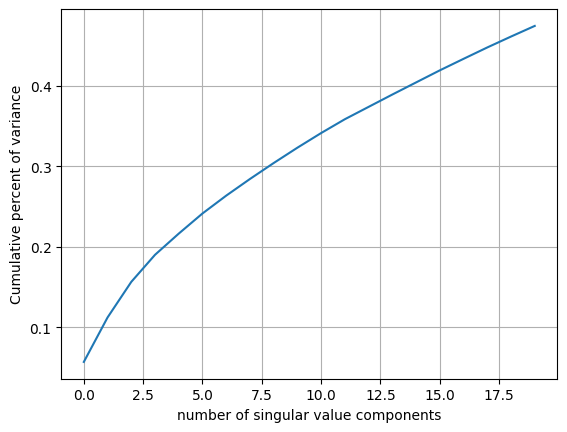

In [276]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [163]:
n = 25 
latent_df = pd.DataFrame(latent_df[:,0:n], index=X_meta.product_id.tolist())
latent_df.shape

(389, 25)

# Latent matrix from event types

In [263]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [236]:
df_event = preprocessing_event(df)

In [239]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [244]:
df_event['rating'] = df_event['event_type'].map(dct)

In [269]:
df_rating = df_event.pivot_table(values='rating', index='user_id', columns='product_id').fillna(0)

In [284]:
df_rating

product_id,1002532,1002540,1002542,1002544,1002633,1003141,1003306,1003310,1003311,1003312,...,35103665,35108524,35108580,35108915,35200115,35200189,43300127,45300048,49800017,49800020
user_id,,,,,,,,,,,,,,,,,,,,,
512483064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
512561891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
512600925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
512625864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
512652590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564240719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564555327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564879838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
df_rating.shape

(186, 310)

In [281]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

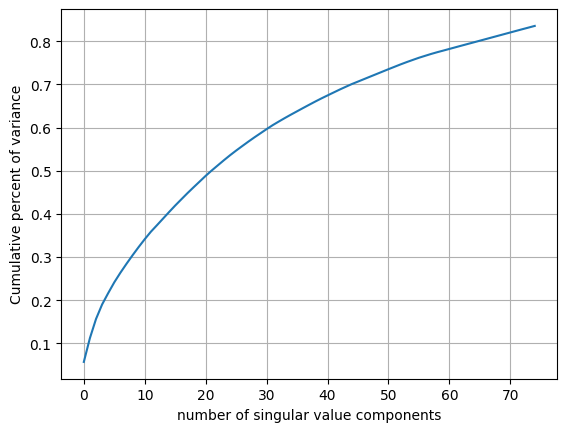

In [282]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [283]:
latent_df_2 = pd.DataFrame(latent_df_2, index=X_meta.product_id.tolist())
latent_df_2.head()

ValueError: Shape of passed values is (186, 75), indices imply (389, 75)